## 목적
- 이전 실험 중, 1~4월 데이터로 학습한 모델이 5월 데이터로 테스트 했을 때 AP가 0.05가 나옴
- 다른 월로 테스트 할 경우, AP 10~30% 
- 5월 upsell target ratio가 0.023으로 random으로 픽해도 0.023
- 모델의 성능이 너무 낮은 이유가 무엇인지 확인할 수 있는 guide? 를 만든다

## 가설
1. 알고리즘
    - lightgbm ovefitting이 너무 심함?
    - RF, XGB로 test
2. 데이터
    - 1~4월의 데이터 분포와 5월의 데이터 분포가 다름
    - 1~4월에서 주요 feature 혹은 feature 간의 상관관계가 5월에는 없음?
    - 각각의 모델 결과 비교(using plot, shap, stats ...)

## 실험 설계 및 결과
- 1,4,5, 각각 train한 모델로 1,4,5 각각 성능 비교
- Random forest
    - 1월 학습시 4,5 월 둘다 0.1로 성능이 낮음
    - 4,5월 학습시 1월은 정말 못 맞추는데 4,5 월은 또 잘맞춤
- LightGBM / Xgboost
    - 1,4월 학습시 5월은 정말 못 맞추는데 1,4월은 또 잘 맞춤
    - 5월 학습시 1월은 적당히 못 맞추는데 4월은 잘 맞춤

|train | test | rf | xgb | lgb |
|------|------|------|------|------|
|1월 | 4월 | 0.08 | 0.2 | **0.21** |
|1월 | 5월 | **0.09** | 0.06 | 0.05 |

|train | test | rf | xgb | lgb |
|------|------|------|------|------|
|4월 | 1월 | 0.05 | 0.16 | **0.18** |
|4월 | 5월 | **0.15** | 0.07 | 0.07 |

|train | test | rf | xgb | lgb |
|------|------|------|------|------|
|5월 | 1월 | 0.06 | **0.1** | 0.1 |
|5월 | 4월 | 0.16 | 0.22 | **0.23** |

## 뭐지......
- 

## Package

In [1]:
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

import pandas as pd
import numpy as np
import pickle
import time
import shap
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()

from sm_utils import sampling, evaluate, save_model, load_model
from sm_utils import make_train_data,  make_test_data, df_to_md_table

In [2]:
DATA_PATH = '/home/dmig/work/upsell/data'
MODEL_PATH = '/home/dmig/work/upsell/model'

In [3]:
RESULT_PATH = '/home/dmig/work/upsell/result/shap_value'

## Load data

In [4]:
df_mart01 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201901.pkl'))
df_mart04 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201904.pkl'))
df_mart05 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201905.pkl'))

df_input06 = pd.read_pickle(os.path.join(DATA_PATH, 'df_input_201906.pkl'))

In [5]:
df_mart01.shape, df_mart04.shape, df_mart05.shape, df_input06.shape

((18176215, 81), (18626176, 81), (18707537, 81), (18855464, 80))

In [6]:
df_mart01['label'].sum()/df_mart01.shape[0], df_mart04['label'].sum()/df_mart04.shape[0], df_mart05['label'].sum()/df_mart05.shape[0]

(0.018491913745518524, 0.027372660926214806, 0.023305954172374483)

## 알고리즘 별 모델링
- input: 월 데이터
- ouput: test 월 별 performance

In [7]:
mart_dict = {'01': df_mart01, '04': df_mart04, '05': df_mart05}

In [8]:
total_feature = list(df_mart01.columns)
feature_cols = [c for c in total_feature if c not in ['svc_mgmt_num', 'label']]

In [21]:
435184/17005933, 74664/1110395

(0.025590127868903165, 0.06724093678375713)

In [26]:
452189/17246012, 57659/870316

(0.026219916813231953, 0.0662506491894898)

In [24]:
df_mart04['overage_5k_3m_or'].value_counts()

0    17698201
1      927975
Name: overage_5k_3m_or, dtype: int64

In [28]:
341820/10604934, 168028/7511394

(0.03223216664997632, 0.022369749210332995)

In [30]:
229541/10446924, 106572/7393178

(0.021972113513987465, 0.014414910610836098)

In [29]:
df_mart01.groupby(['family_yn', 'label']).size()

family_yn  label
0          0         7393178
           1          106572
1          0        10446924
           1          229541
dtype: int64

In [25]:
df_mart04.groupby(['overage_5k_3m_or', 'label']).size()

overage_5k_3m_or  label
0                 0        17246012
                  1          452189
1                 0          870316
                  1           57659
dtype: int64

In [9]:
def lgb_model(train_month, x_trn, y_trn, x_val, y_val, feature_cols=feature_cols):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': True,
        'num_leaves': 64,
        'learning_rate': 0.05,
        'num_threads': 40,
    }

    lgb_trn = lgb.Dataset(x_trn, y_trn, feature_name=feature_cols)
    lgb_val = lgb.Dataset(x_val, y_val, feature_name=feature_cols)

    t1 = time.time()
    clf = lgb.train(lgb_params,
                    train_set=lgb_trn,
                    valid_sets=[lgb_trn, lgb_val],
                    num_boost_round=500,
                    early_stopping_rounds=100,
                    verbose_eval=200)
    print('elapsed time:', time.time()-t1)
        
    return clf

In [10]:
def xgb_model(train_month, x_trn, y_trn, x_val, y_val, feature_cols=feature_cols):
    xgb_params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc', #logloss, error, auc
            'n_estimators': 500,
            'eta': 0.1,
            'max_depth': 6,
            'min_child_weight': 1,
            'scale_pos_weight': 4, # neg/pos
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 23,
            'nthread': 40,
            'verbosity': 1
        }
        
    clf = xgb.XGBClassifier(**xgb_params)
    t1 = time.time()
    clf.fit(x_trn, y_trn.label.values, 
             eval_set=[(x_trn, y_trn.label.values), 
                       (x_val, y_val.label.values)],
            early_stopping_rounds=100, verbose=200)
    print('elapsed time: ', time.time()-t1)

    return clf

In [15]:
def rf_model(train_month, x_trn, y_trn, x_val, y_val, feature_cols=feature_cols):
    rf_params = {
        'n_estimators': 1000,
        'max_depth':8,
        'n_jobs': 40,
        'random_state': 23,
    }

    clf = RandomForestClassifier(**rf_params)
    clf.fit(x_trn, y_trn)
    
    return clf

train month +++++:  01
make_train_data +++
label/sample:  0.2
sample/total:  0.09245956872759263
make_data_for_modeling---
train model +++++:  01
random forest +++++:  01
xgboost +++++:  01
[0]	validation_0-auc:0.756812	validation_1-auc:0.75686
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[200]	validation_0-auc:0.935088	validation_1-auc:0.931337
[400]	validation_0-auc:0.951938	validation_1-auc:0.946386
[499]	validation_0-auc:0.956465	validation_1-auc:0.95016
elapsed time:  474.9795684814453
lightgbm +++++:  01
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.940509	valid_1's auc: 0.938751
[400]	training's auc: 0.952801	valid_1's auc: 0.949827
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.955849	valid_1's auc: 0.952172
elapsed time: 87.70987486839294
test_month +++++:  01
same momth
test_month +++++:  04
        

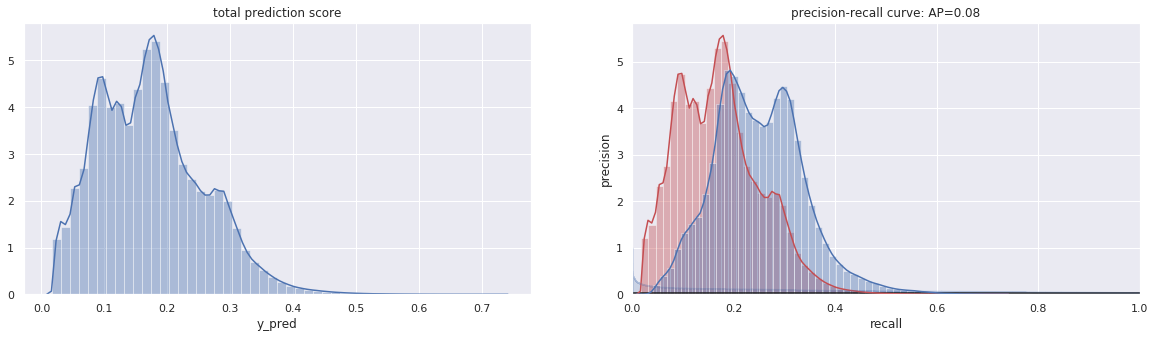

save model to  /home/dmig/work/upsell/model/rf_01_04.pkl
        acc    recall  precision  f1_score      auc
0  0.855807  0.596113   0.109178  0.184555  0.81491
         pred: 1   pred: 0
true: 1   303927    205921
true: 0  2479841  15636487


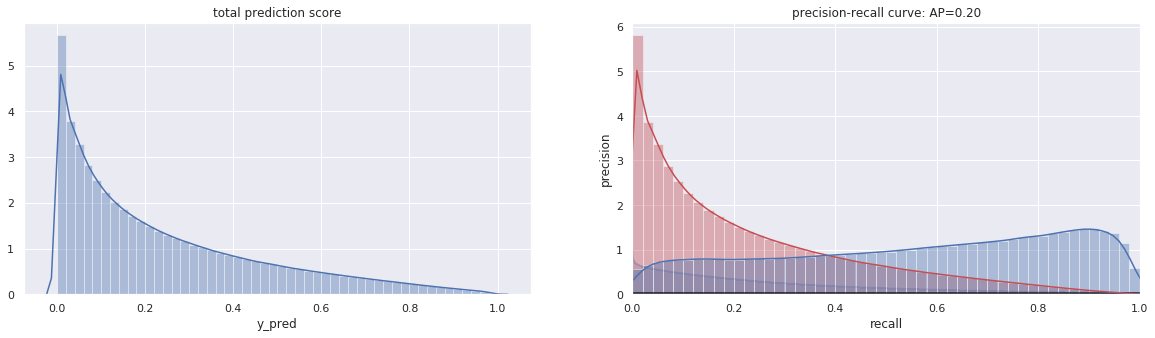

save model to  /home/dmig/work/upsell/model/xgb_01_04.pkl
        acc    recall  precision  f1_score       auc
0  0.839384  0.623019   0.101904  0.175158  0.817405
         pred: 1   pred: 0
true: 1   317645    192203
true: 0  2799466  15316862


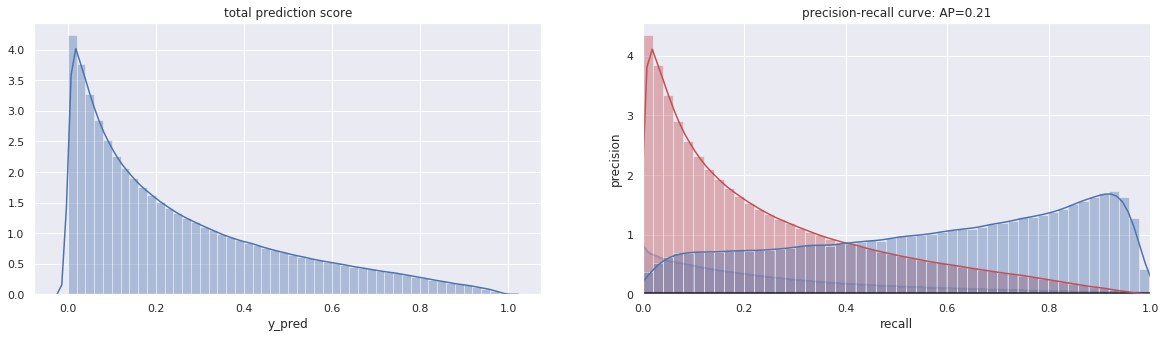

save model to  /home/dmig/work/upsell/model/lgb_01_04.pkl
test_month +++++:  05
       acc    recall  precision  f1_score      auc
0  0.97637  0.009367   0.287161  0.018142  0.74492
         pred: 1   pred: 0
true: 1     4084    431913
true: 0    10138  18261402


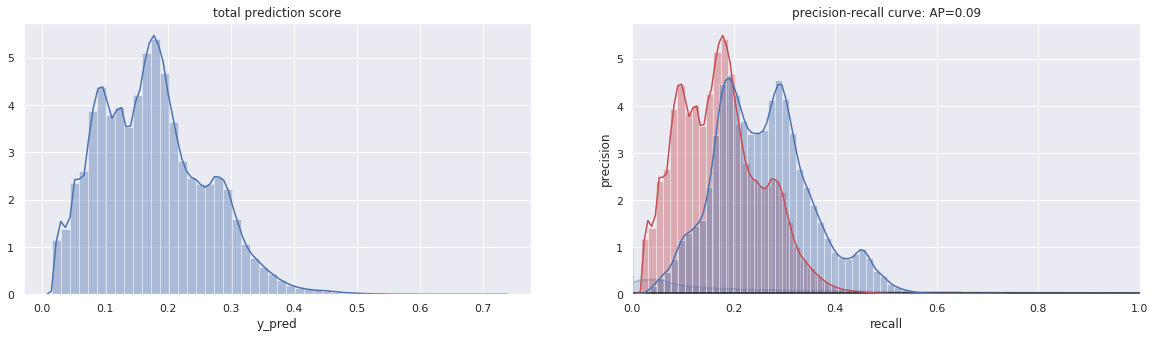

save model to  /home/dmig/work/upsell/model/rf_01_05.pkl
        acc    recall  precision  f1_score       auc
0  0.726714  0.505419   0.043063  0.079363  0.681119
         pred: 1   pred: 0
true: 1   220361    215636
true: 0  4896865  13374675


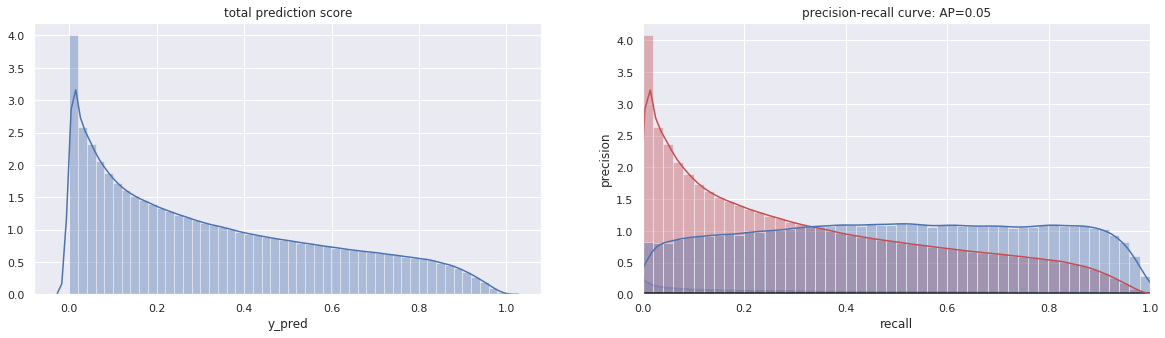

save model to  /home/dmig/work/upsell/model/xgb_01_05.pkl
        acc    recall  precision  f1_score       auc
0  0.703953  0.547114   0.042754   0.07931  0.681392
         pred: 1   pred: 0
true: 1   238540    197457
true: 0  5340856  12930684


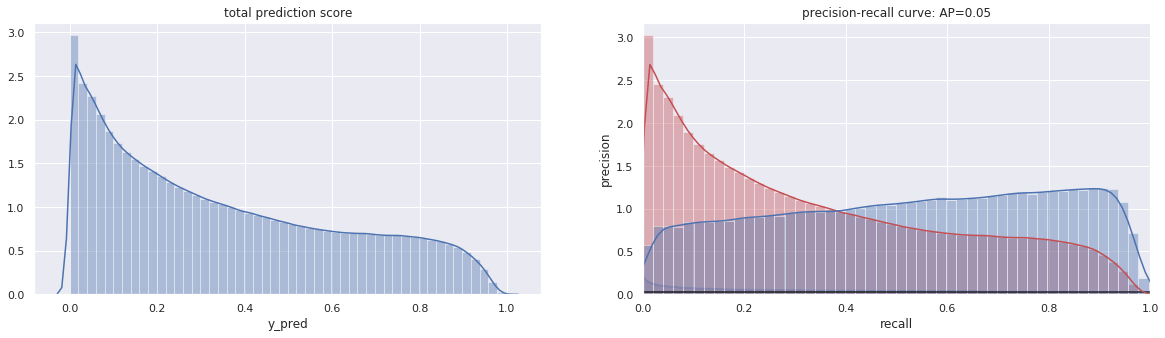

save model to  /home/dmig/work/upsell/model/lgb_01_05.pkl
train month +++++:  04
make_train_data +++
label/sample:  0.2
sample/total:  0.13686330463107405
make_data_for_modeling---
train model +++++:  04
random forest +++++:  04
xgboost +++++:  04
[0]	validation_0-auc:0.75196	validation_1-auc:0.751059
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[200]	validation_0-auc:0.904013	validation_1-auc:0.900333
[400]	validation_0-auc:0.922877	validation_1-auc:0.917405
[499]	validation_0-auc:0.931533	validation_1-auc:0.925444
elapsed time:  419.42015266418457
lightgbm +++++:  04
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.907819	valid_1's auc: 0.905714
[400]	training's auc: 0.929325	valid_1's auc: 0.92658
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.934014	valid_1's auc: 0.930845
elapsed time: 130.49461770057678
tes

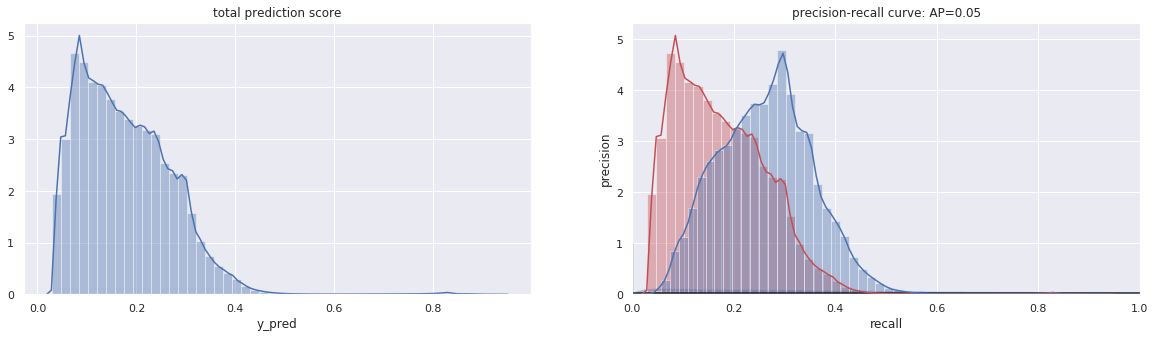

save model to  /home/dmig/work/upsell/model/rf_04_01.pkl
        acc    recall  precision  f1_score       auc
0  0.778176  0.866664   0.068085  0.126252  0.900335
         pred: 1   pred: 0
true: 1   291297     44816
true: 0  3987109  13852993


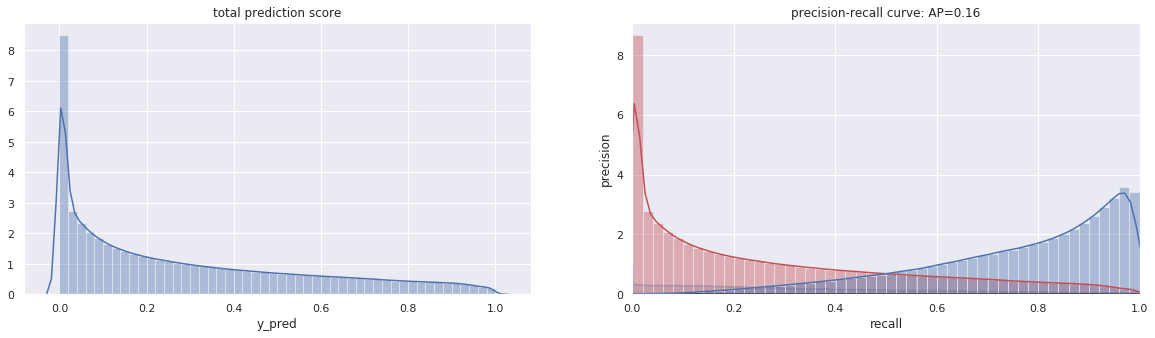

save model to  /home/dmig/work/upsell/model/xgb_04_01.pkl
        acc    recall  precision  f1_score       auc
0  0.776243  0.878466   0.068325  0.126789  0.907357
         pred: 1   pred: 0
true: 1   295264     40849
true: 0  4026205  13813897


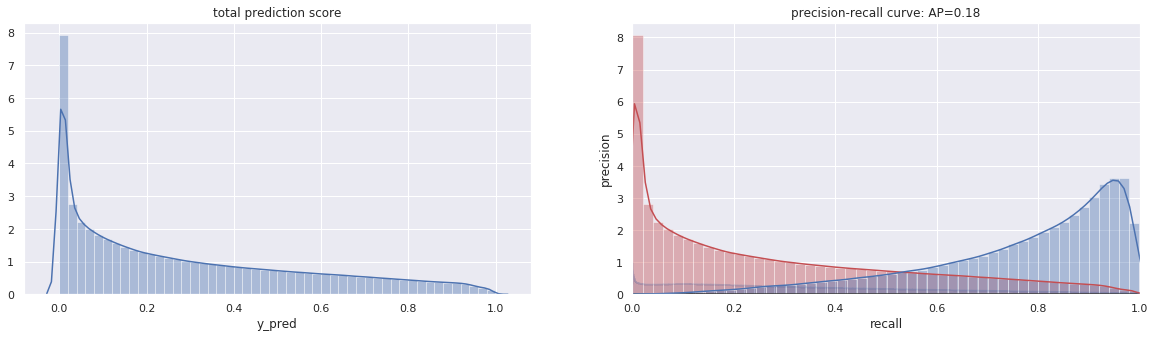

save model to  /home/dmig/work/upsell/model/lgb_04_01.pkl
test_month +++++:  04
same momth
test_month +++++:  05
        acc    recall  precision  f1_score       auc
0  0.977482  0.072223   0.652825  0.130057  0.768136
         pred: 1   pred: 0
true: 1    31489    404508
true: 0    16746  18254794


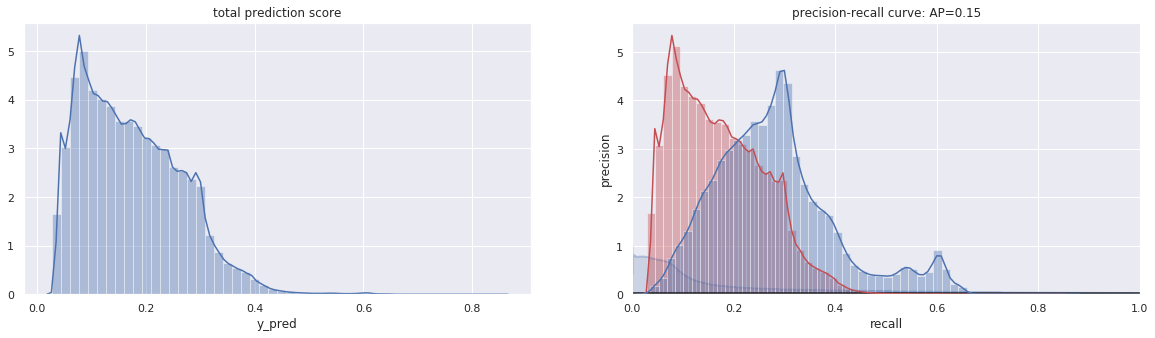

save model to  /home/dmig/work/upsell/model/rf_04_05.pkl
        acc    recall  precision  f1_score       auc
0  0.753052  0.598926   0.055488  0.101567  0.747573
         pred: 1   pred: 0
true: 1   261130    174867
true: 0  4444922  13826618


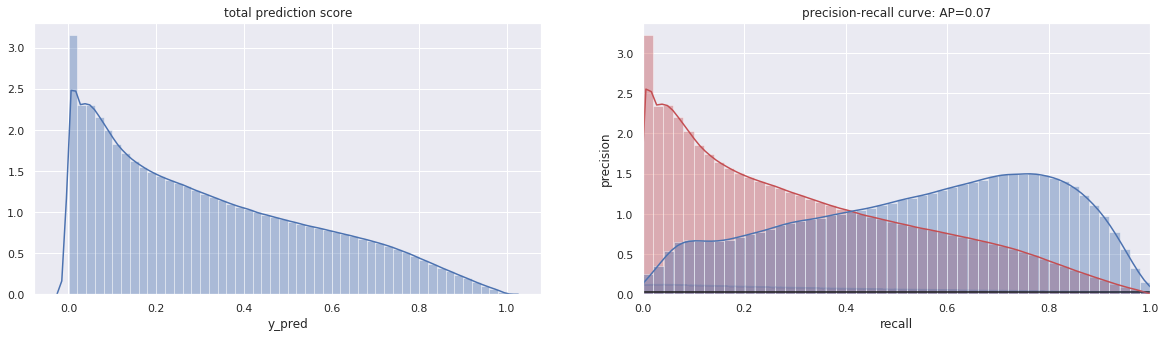

save model to  /home/dmig/work/upsell/model/xgb_04_05.pkl
        acc    recall  precision  f1_score       auc
0  0.711528  0.656346    0.05172  0.095885  0.748347
         pred: 1   pred: 0
true: 1   286165    149832
true: 0  5246766  13024774


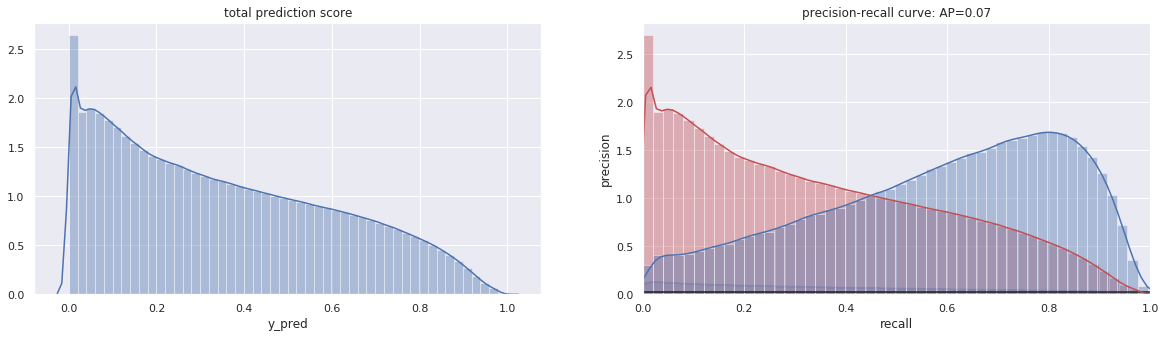

save model to  /home/dmig/work/upsell/model/lgb_04_05.pkl
train month +++++:  05
make_train_data +++
label/sample:  0.2
sample/total:  0.11652977086187241
make_data_for_modeling---
train model +++++:  05
random forest +++++:  05
xgboost +++++:  05
[0]	validation_0-auc:0.745116	validation_1-auc:0.74425
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[200]	validation_0-auc:0.82765	validation_1-auc:0.823354
[400]	validation_0-auc:0.839899	validation_1-auc:0.831375
[499]	validation_0-auc:0.843635	validation_1-auc:0.833063
elapsed time:  363.9716901779175
lightgbm +++++:  05
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.827405	valid_1's auc: 0.825992
[400]	training's auc: 0.837901	valid_1's auc: 0.833599
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.841158	valid_1's auc: 0.835164
elapsed time: 176.5836730003357
test_

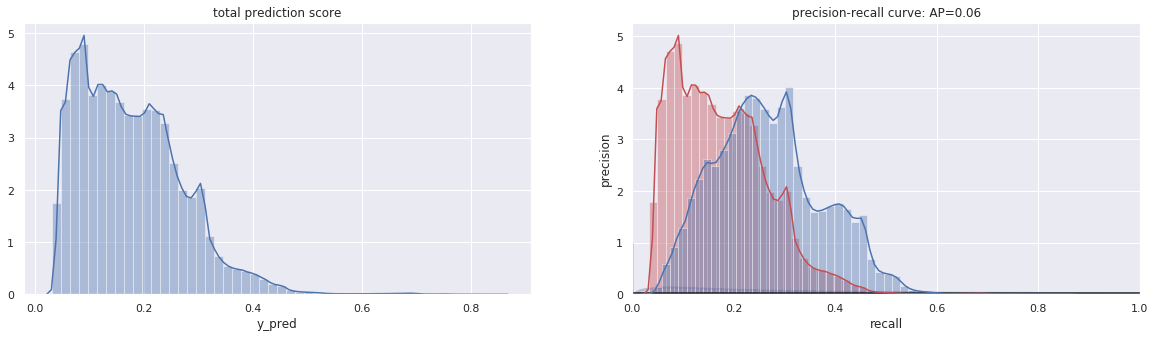

save model to  /home/dmig/work/upsell/model/rf_05_01.pkl
        acc    recall  precision  f1_score       auc
0  0.731434  0.766391   0.050902  0.095464  0.831092
         pred: 1   pred: 0
true: 1   257594     78519
true: 0  4802990  13037112


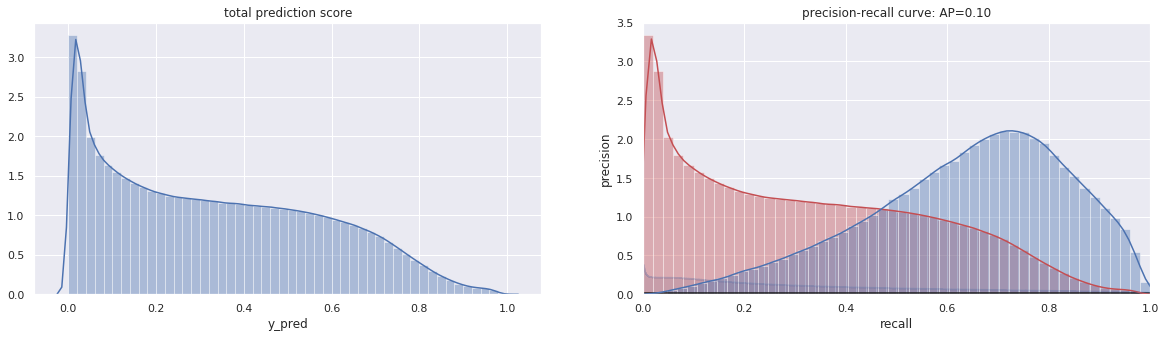

save model to  /home/dmig/work/upsell/model/xgb_05_01.pkl
        acc    recall  precision  f1_score       auc
0  0.721437  0.769896    0.04934  0.092737  0.829379
         pred: 1   pred: 0
true: 1   258772     77341
true: 0  4985872  12854230


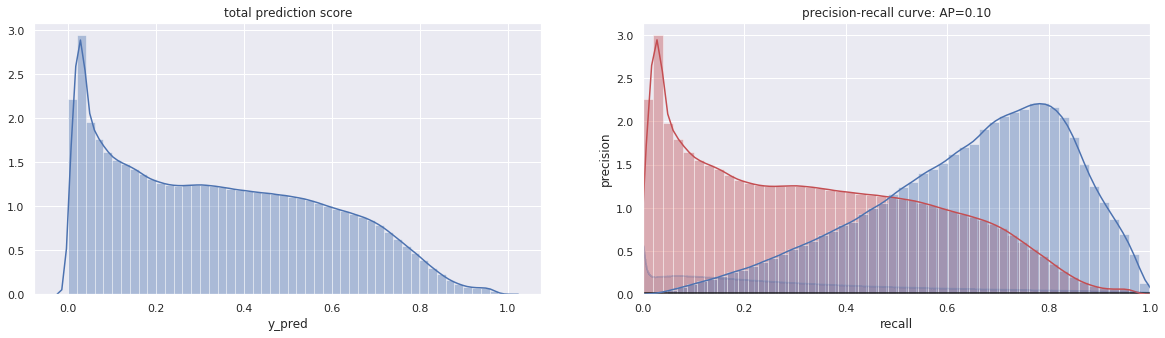

save model to  /home/dmig/work/upsell/model/lgb_05_01.pkl
test_month +++++:  04
       acc   recall  precision  f1_score       auc
0  0.97336  0.09678    0.58024   0.16589  0.771094
         pred: 1   pred: 0
true: 1    49343    460505
true: 0    35696  18080632


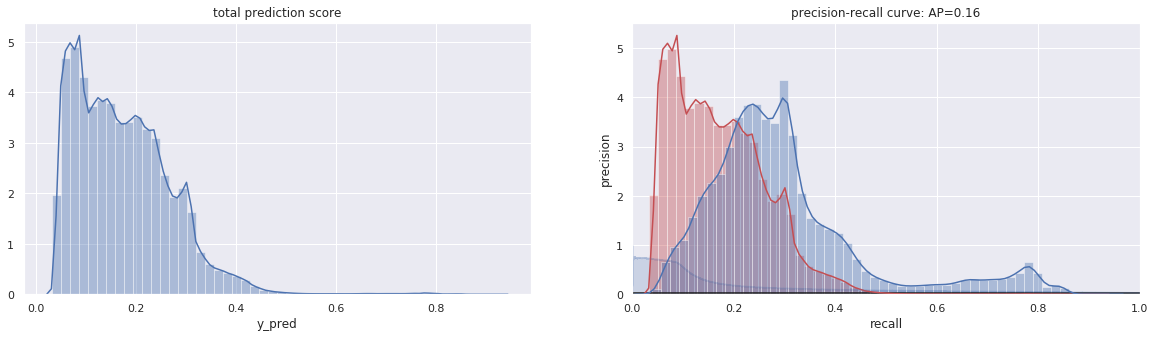

save model to  /home/dmig/work/upsell/model/rf_05_04.pkl
        acc    recall  precision  f1_score       auc
0  0.739472  0.767107   0.076314  0.138817  0.839356
         pred: 1   pred: 0
true: 1   391108    118740
true: 0  4733902  13382426


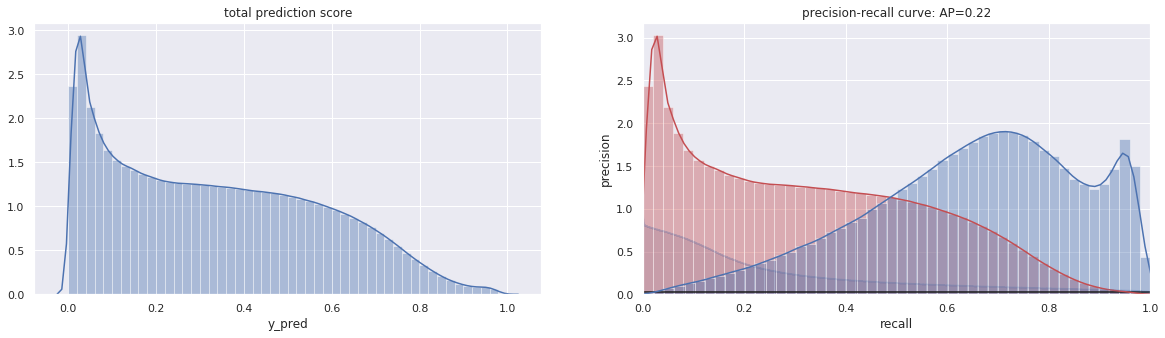

save model to  /home/dmig/work/upsell/model/xgb_05_04.pkl
        acc  recall  precision  f1_score      auc
0  0.731997  0.7702    0.07455  0.135942  0.83738
         pred: 1   pred: 0
true: 1   392685    117163
true: 0  4874706  13241622


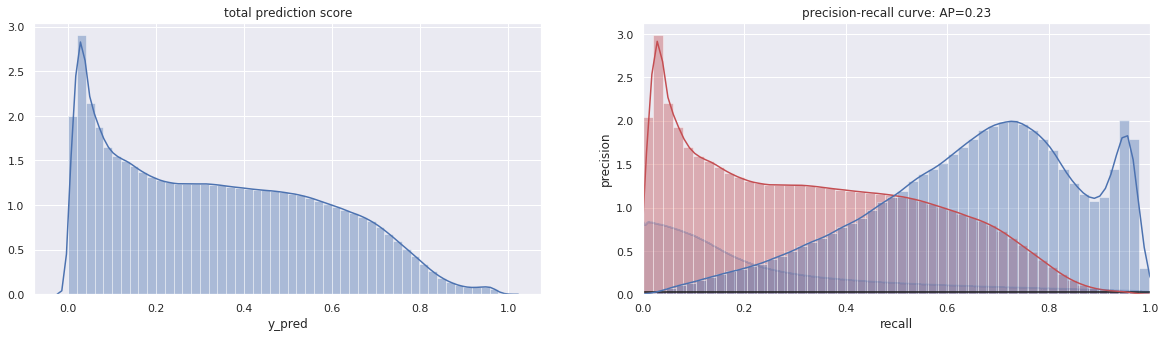

save model to  /home/dmig/work/upsell/model/lgb_05_04.pkl
test_month +++++:  05
same momth


In [16]:
for train_month in list(mart_dict.keys()):
    print('train month +++++: ', train_month)

    # train data
    train_result = make_train_data(mart_dict[train_month])
    x_trn = train_result['trn']['x']
    y_trn = train_result['trn']['y']
    x_val = train_result['val']['x']
    y_val = train_result['val']['y']
    
    # train model
    print('train model +++++: ', train_month)
    print('random forest +++++: ', train_month)
    rf_clf = rf_model(train_month, x_trn, y_trn, x_val, y_val, feature_cols=feature_cols)
    
    print('xgboost +++++: ', train_month)
    xgb_clf = xgb_model(train_month, x_trn, y_trn, x_val, y_val, feature_cols=feature_cols)
    
    print('lightgbm +++++: ', train_month)
    lgb_clf = lgb_model(train_month, x_trn, y_trn, x_val, y_val, feature_cols=feature_cols)

    
    for test_month in list(mart_dict.keys()):
        print('test_month +++++: ', test_month)
        if train_month == test_month:
            print('same momth')
            continue
        
        test_result = make_test_data(mart_dict[test_month])
        x_test = test_result['x']
        y_test = test_result['y']
        
        
        eval_result = evaluate(x_test, y_test.label.values, rf_clf, clf_name='rf')
        save_model(rf_clf, '{}_{}_{}.pkl'.format('rf', train_month, test_month))
        
        eval_result = evaluate(x_test, y_test.label.values, xgb_clf, clf_name='xgb')
        save_model(xgb_clf, '{}_{}_{}.pkl'.format('xgb', train_month, test_month))
        
        eval_result = evaluate(x_test, y_test.label.values, lgb_clf, clf_name='lgb')
        save_model(lgb_clf, '{}_{}_{}.pkl'.format('lgb', train_month, test_month))